# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we discussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal (underfitting). This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [1]:
# Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
#import dataset

data = pd.read_csv('../PS_20174392719_1491204439457_log.csv')


In [5]:
# get sample from data

sample = data.sample(n=100000)

In [6]:
sample.to_csv('../sample.csv')

In [7]:
sample = pd.read_csv('../sample.csv')

In [8]:
sample.head()

,Unnamed: 0,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,3216374,249,CASH_OUT,74390.34,C1579862536,106019.0,31628.66,C1395254081,22034.00,0.00,0,0
1,6148821,546,CASH_IN,198046.01,C878219353,49655.0,247701.01,C1584169449,37475.12,0.00,0,0
2,4254948,306,CASH_IN,520602.03,C1774844620,56113.0,576715.03,C1421257628,165384.44,0.00,0,0
3,5930786,404,CASH_OUT,91118.35,C2106079390,16620.0,0.00,C1302037827,2016905.18,2108023.53,0,0
4,2936025,229,PAYMENT,799.27,C997280206,61608.0,60808.73,M594193738,0.00,0.00,0,0


In [9]:
sample.shape

(100000, 12)

In [10]:
sample.dtypes

Unnamed: 0          int64
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [11]:
# did not get any flagged fraud
sample['isFlaggedFraud'].unique()

array([0])

In [12]:
sample['isFraud'].unique()

array([0, 1])

In [13]:
sample['type'].unique()

array(['CASH_OUT', 'CASH_IN', 'PAYMENT', 'TRANSFER', 'DEBIT'],
      dtype=object)

In [ ]:
# why is this taking so long??!!!
# do not run
#data['nameOrig'].unique().sum()

In [ ]:
# do not run
#data['nameDest'].unique().sum()

### What is the distribution of the outcome? 

In [14]:
# Outcome: isFraud

count_fraud = sample['isFraud'].value_counts()

count_fraud/len(sample)

0    0.99862
1    0.00138
Name: isFraud, dtype: float64

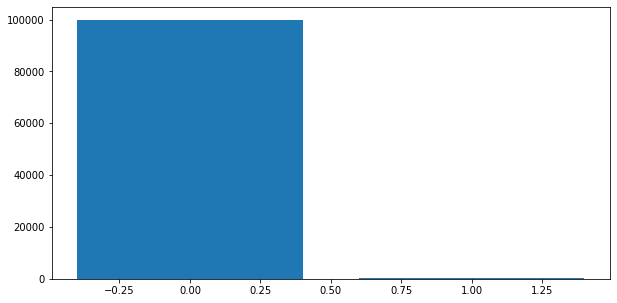

In [15]:

x = count_fraud.index
y = count_fraud.values

f, ax = plt.subplots(figsize=(10, 5))

plt.bar(x,y)
plt.show()

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [16]:
# Step
# Original values: maps a unit of time in the real world. 
# In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation). (From Kaggle)

sample['step'].unique()

array([249, 546, 306, 404, 229,  39, 379, 256, 335, 134, 205, 279, 372,
       163, 278,  36, 184, 235, 157, 349, 181, 332, 301, 183, 277, 225,
        11, 397, 329, 131, 254, 375, 139, 236, 307, 688, 154, 395,  20,
       333, 325, 354, 324, 265, 211, 187, 350, 280, 330, 373, 309,   9,
        19, 380, 327, 405, 226, 140, 232, 300,  10, 305, 331, 207, 161,
       259, 138, 228, 334,  14,  15, 251, 180, 659,  16, 303, 130,  41,
       234, 563, 129,  42,  35, 169, 396, 328,  33,  12, 376, 283, 326,
       189, 370,  44, 135, 274, 250,  95, 490, 378, 348, 164,  24,  47,
       311, 358, 137, 136, 210, 203, 206, 178, 374, 710, 346, 119, 285,
       394, 238, 240, 257, 132, 355, 214, 252, 156, 190, 255, 227, 160,
        18, 400, 356, 308, 281, 185, 179, 377, 208, 275, 347, 182, 273,
       304, 323, 253, 261, 133, 401, 403, 298, 142, 402, 492, 381, 302,
       213, 204, 141, 260, 351, 215, 159, 596, 216,  46, 186,  40, 153,
       162,  43, 231, 399, 522, 212, 177,  48, 166, 230, 514,   

In [17]:
# turn into unit = days
# Too many different values, will "bin" them into days
# diminuir a dimensionalidade

sample['step'] = (sample['step']/24).astype(int)


In [18]:
# New values

sample['step'].unique()

array([10, 22, 12, 16,  9,  1, 15, 13,  5,  8, 11,  6,  7, 14,  0, 28, 27,
       23,  3, 20, 29,  4, 24, 21,  2, 18, 17, 26, 19, 25, 30])

In [19]:
# drop two categorical variables with too many unique values
# drop 'isFlaggedFraud' - is downstream from isFraud

# will keep type

sample.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

In [20]:
# check
sample.columns

Index(['Unnamed: 0', 'step', 'type', 'amount', 'oldbalanceOrg',
       'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [21]:
# check for NaNs

sample.isna().sum()

Unnamed: 0        0
step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [22]:
# turn type into a numerical

# returns whole data set, categorical variables turned into ordinal data with dummies
# did it automatically drop the type column?
sample_dummy = pd.get_dummies(sample)
sample_dummy.head()

,Unnamed: 0,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,3216374,10,74390.34,106019.0,31628.66,22034.00,0.00,0,0,1,0,0,0
1,6148821,22,198046.01,49655.0,247701.01,37475.12,0.00,0,1,0,0,0,0
2,4254948,12,520602.03,56113.0,576715.03,165384.44,0.00,0,1,0,0,0,0
3,5930786,16,91118.35,16620.0,0.00,2016905.18,2108023.53,0,0,1,0,0,0
4,2936025,9,799.27,61608.0,60808.73,0.00,0.00,0,0,0,0,1,0


In [27]:
# drop old index

sample_dummy.drop(['Unnamed: 0'], axis=1, inplace=True)

In [28]:
sample_dummy.dtypes

step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
type_CASH_IN        uint8
type_CASH_OUT       uint8
type_DEBIT          uint8
type_PAYMENT        uint8
type_TRANSFER       uint8
dtype: object

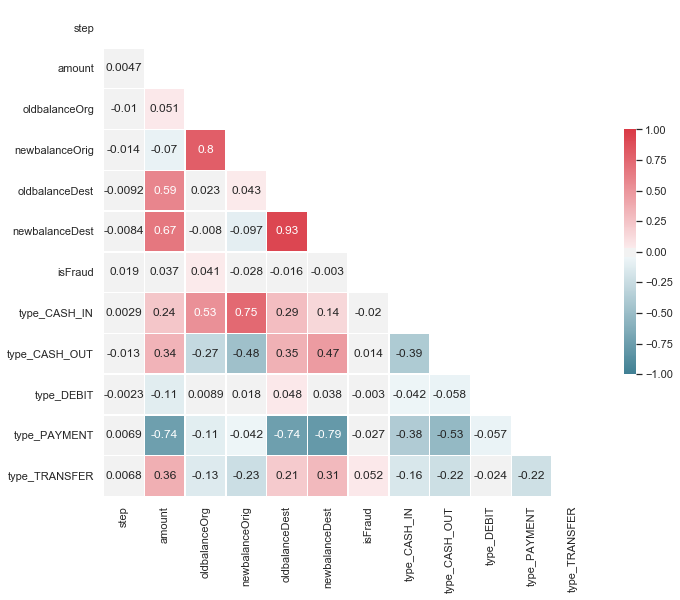

In [29]:
# Heatmap

# check with multilinear
corr = sample_dummy.corr(method='spearman')

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# annot=True so as to show the value
# Draw the heatmap with the mask and correct aspect ratio
# vmin=-1, vmax=1 gets the whole scale
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
             square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [30]:
# will drop: 
# 1. 'newbalanceOrig' (high collinearity with 'oldbalanceOrg', reason to think it's the same information 
# given in two different ways)
# 2. 'newbalanceDest' (high collinearity with 'oldbalanceDest', also reason to think it's the same information
# given in two different ways)

sample_dummy.drop(['newbalanceOrig', 'newbalanceDest'], axis=1, inplace=True)

In [31]:
sample_dummy.columns

Index(['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'isFraud',
       'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER'],
      dtype='object')

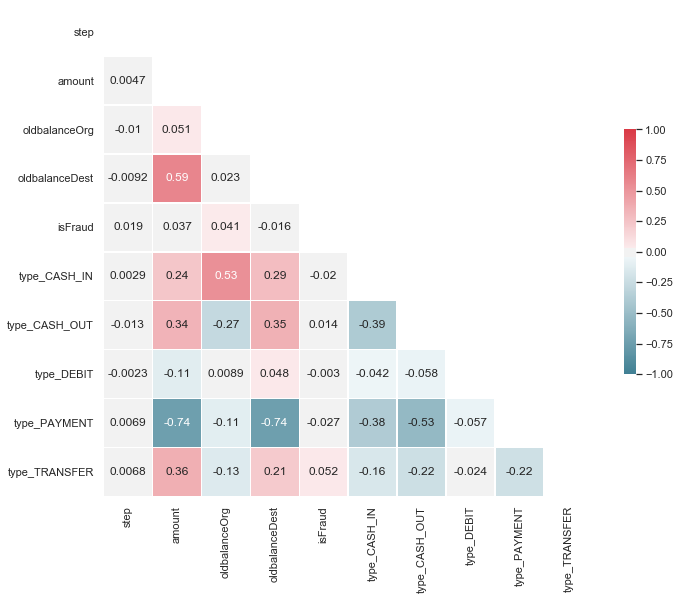

In [32]:
# Heatmap

# check with multilinear
corr = sample_dummy.corr(method='spearman')

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# annot=True so as to show the value
# Draw the heatmap with the mask and correct aspect ratio
# vmin=-1, vmax=1 gets the whole scale
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
             square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### Run a logistic regression classifier and evaluate its accuracy.

In [33]:
# let's separate the dataframe into features and target

X = sample_dummy.drop(['isFraud'], axis =1) # features
y = sample_dummy['isFraud'] # target

# splitting the data to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)


In [34]:
from sklearn.linear_model import LogisticRegression

# Initialize model and define hyperparameters
model = LogisticRegression(max_iter=2000)

# max_iter=2000 above avoids error message (max number of interations reached)
# if max number of interations reached, we may not reach the best model

# here we train the model
model.fit(X_train, y_train)
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

#predictions: test data
y_pred = model.predict(X_test)

# compare predictions to actual answers
print('Confusion matrix')
print(confusion_matrix(y_pred,y_test))
print('-------------------------------------------------------')

# accuracy_score
# fitted X_test data vs. y_test data (actual answer)
print('Accuracy score')
print(accuracy_score(y_pred,y_test))

print('-------------------------------------------------------')
# classification report
print('Classification report')
print(classification_report(y_pred,y_test))

Confusion matrix
[[19971    29]
 [    0     0]]
-------------------------------------------------------
Accuracy score
0.99855
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20000
           1       0.00      0.00      0.00         0

    accuracy                           1.00     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       1.00      1.00      1.00     20000



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Now pick a model of your choice and evaluate its accuracy.

In [35]:
# let's do a decision tree

# import model
from sklearn.tree import DecisionTreeClassifier

# create instance of the model
dtc = DecisionTreeClassifier()

# train the model
dtc.fit(X_train, y_train)

#predictions: test data
y_pred = dtc.predict(X_test)

# compare predictions to actual answers
print('Confusion matrix')
print(confusion_matrix(y_pred,y_test))
print('-------------------------------------------------------')

# accuracy_score
# fitted X_test data vs. y_test data (actual answer)
print('Accuracy score')
print(accuracy_score(y_pred,y_test))

print('-------------------------------------------------------')
# classification report
print('Classification report')
print(classification_report(y_pred,y_test))

Confusion matrix
[[19956    13]
 [   15    16]]
-------------------------------------------------------
Accuracy score
0.9986
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19969
           1       0.55      0.52      0.53        31

    accuracy                           1.00     20000
   macro avg       0.78      0.76      0.77     20000
weighted avg       1.00      1.00      1.00     20000



In [38]:
# Random forest

from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import ridge_regression

# create an instance of the model
forest = RandomForestClassifier()

# fit the model
forest.fit(X_train, y_train)

# predict for test 
y_pred = forest.predict(X_test)

# compare predictions to actual answers
print('Confusion matrix')
print(confusion_matrix(y_pred,y_test))
print('-------------------------------------------------------')

# accuracy_score
# fitted X_test data vs. y_test data (actual answers)
print('Accuracy score')
print(forest.score(X_test,y_test))
#print(accuracy_score(y_pred,y_test)) does the exact same thing as forest.score(X_test,y_test)
print('-------------------------------------------------------')

# classification report
print('Classification report')
print(classification_report(y_pred,y_test)) 

# https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56

Confusion matrix
[[19969    18]
 [    2    11]]
-------------------------------------------------------
Accuracy score
0.999
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19987
           1       0.38      0.85      0.52        13

    accuracy                           1.00     20000
   macro avg       0.69      0.92      0.76     20000
weighted avg       1.00      1.00      1.00     20000



In [37]:
# let's do some downsampling

from sklearn.utils import resample

# separate input features and target
X = sample_dummy.drop(['isFraud'], axis =1) # features
y = sample_dummy['isFraud'] # target

#split into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# concatenate training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate majority and minority classes
not_fraud = X[X.isFraud == 0]
fraud = X[X.isFraud == 1]

#downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace=False, # sample without replacemente
                                n_samples=len(fraud), # match minority n
                                random_state=0) #reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# check results
downsampled['isFraud'].value_counts()

1    109
0    109
Name: isFraud, dtype: int64

In [39]:
# Now let's run the model with downsampling

# separate input features and target
X = downsampled.drop(['isFraud'], axis=1) # features
y = downsampled['isFraud'] # target

#split into training and testing subsets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)´
# we don't do this again
# we use X, y to train, then test on real data (X_test and y_test above)

# create an instance of the model
forest = RandomForestClassifier()

# fit the model
forest.fit(X, y)

# predict for test data
y_pred = forest.predict(X_test)

# compare predictions to actual answers
print('Confusion matrix')
print(confusion_matrix(y_pred,y_test))
print('-------------------------------------------------------')

# accuracy_score
# fitted X_test data vs. y_test data (actual answers)
print('Accuracy score')
print(forest.score(X_test,y_test))
#print(accuracy_score(y_pred,y_test)) does the exact same thing as forest.score(X_test,y_test)
print('-------------------------------------------------------')

# classification report
print('Classification report')
print(classification_report(y_pred,y_test)) 

Confusion matrix
[[18906     2]
 [ 1065    27]]
-------------------------------------------------------
Accuracy score
0.94665
-------------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     18908
           1       0.93      0.02      0.05      1092

    accuracy                           0.95     20000
   macro avg       0.94      0.51      0.51     20000
weighted avg       0.95      0.95      0.92     20000



In [40]:
# checking
print(len(X))
print(len(y))
print(len(X_test))
print(len(y_test))

218
218
20000
20000


### Which model worked better and how do you know?

In [ ]:
# Your response here

# Random Forest with downsampling had very poor results wrt recall of fraudulent transactions
# f1-score is thus very low
# Good results wrt precision of fraudulent transactions, but this is not the most relevant metric in this case

# Of the models tested above, the best one seems to be Random Forest Classifier without downsampling
# It had the highest recall for fraudulent transactions of all three models

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.